In [1]:
using BCFWstruct

In [2]:
function lossCB(param, y, ybar)
  abs(ybar - y)
end

function featureCB(param, x, y)
  [y,
   y * x,
   y * x^2,
   y * x^3,
   - 0.5 * y^2]
end

function oracleCB(param, model, x, y)  # loss-augmented inference
  w = model.w
  z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    yhat = Float64[]
  if w[5] > 0
    yhat = [z - 1, z + 1] / w[5]
    yhat = max(min(yhat, 1),-1)
  end
    append!(yhat, [-1, 1])   
    augLoss = y_::Vector{Float64} -> abs(y_ - y) + z * y_ - 0.5 * y_.^2 * w[5]
  worse = indmax(augLoss(yhat))
    yhat = yhat[worse]
end

function oracleCB(param, model, x)    # inference
  w = model.w
    z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    y = z / w[5]
end

oracleCB (generic function with 2 methods)

In [3]:
x = collect(linspace(-pi,pi,21))
y = 0.5*sin(x)
y = y + 0.1*randn(size(y));

In [4]:
xr = collect(linspace(minimum(x), maximum(x), 1024))
yr = collect(linspace(-1,1,1024));

In [5]:
param = BCFWstruct.Param(
    x,
    y,
    lossCB,
    oracleCB,
    featureCB
    )

BCFWstruct.Param{Float64,Float64}([-3.14159,-2.82743,-2.51327,-2.19911,-1.88496,-1.5708,-1.25664,-0.942478,-0.628319,-0.314159  …  0.314159,0.628319,0.942478,1.25664,1.5708,1.88496,2.19911,2.51327,2.82743,3.14159],[-0.00853983,-0.309255,-0.271232,-0.342945,-0.526396,-0.510696,-0.54101,-0.425326,-0.237026,-0.0651087  …  0.330254,0.211964,0.243429,0.67993,0.528908,0.456445,0.554805,0.258425,0.074824,0.0439403],lossCB,oracleCB,featureCB)

In [6]:
options = BCFWstruct.Options(Float64, Float64, 5, length(x))
options.num_passes = 2000
options.gap_threshold = 0.01;
options.debug = true;

In [7]:
model, progress = BCFWstruct.solverBCFW(param, options);

running BCFW on 21 examples. The options are as follows:

BCFWstruct.Options{Float64,Float64}(Float32[0.0f0,0.0f0,0.0f0,0.0f0,0.0f0],0x00000000000007d0,true,true,Inf32,true,0x0000000000000001,uniform::BCFWstruct.Sample,100,0.04761905f0,(Float64[],Float64[]),0.01,0x000000000000000a)
pass 1 (iteration 21), SVM primal = 0.796107, SVM dual = 0.077083, duality gap = 0.719025, train_error = 0.305863 
pass 2 (iteration 42), SVM primal = 0.826386, SVM dual = 0.099456, duality gap = 0.726930, train_error = 0.385318 
pass 3 (iteration 63), SVM primal = 0.533878, SVM dual = 0.122905, duality gap = 0.410974, train_error = 0.125959 
pass 4 (iteration 84), SVM primal = 0.518843, SVM dual = 0.140970, duality gap = 0.377873, train_error = 0.123403 
pass 5 (iteration 105), SVM primal = 0.476712, SVM dual = 0.155054, duality gap = 0.321658, train_error = 0.092968 
pass 6 (iteration 126), SVM primal = 0.482373, SVM dual = 0.167625, duality gap = 0.314748, train_error = 0.099050 
pass 7 (iteration 147), S

In [8]:
model

BCFWstruct.Model(Float32[0.033215027f0,0.8587602f0,-0.0152944345f0,-0.089262f0,2.0394223f0],0.5555053f0)

 (iteration 41538), SVM primal = 0.452374, SVM dual = 0.438487, duality gap = 0.013888, train_error = 0.080120 
pass 1979 (iteration 41559), SVM primal = 0.452373, SVM dual = 0.438496, duality gap = 0.013877, train_error = 0.080119 
pass 1980 (iteration 41580), SVM primal = 0.452373, SVM dual = 0.438506, duality gap = 0.013868, train_error = 0.080120 
Duality gap check: gap = 0.013868 at pass 1980 (iteration 41580)
pass 1981 (iteration 41601), SVM primal = 0.452372, SVM dual = 0.438515, duality gap = 0.013857, train_error = 0.080119 
pass 1982 (iteration 41622), SVM primal = 0.452371, SVM dual = 0.438525, duality gap = 0.013847, train_error = 0.080119 
pass 1983 (iteration 41643), SVM primal = 0.452371, SVM dual = 0.438534, duality gap = 0.013837, train_error = 0.080119 
pass 1984 (iteration 41664), SVM primal = 0.452371, SVM dual = 0.438544, duality gap = 0.013827, train_error = 0.080119 
pass 1985 (iteration 41685), SVM primal = 0.452371, SVM dual = 0.438553, duality gap = 0.013817, 

In [11]:
using PyPlot

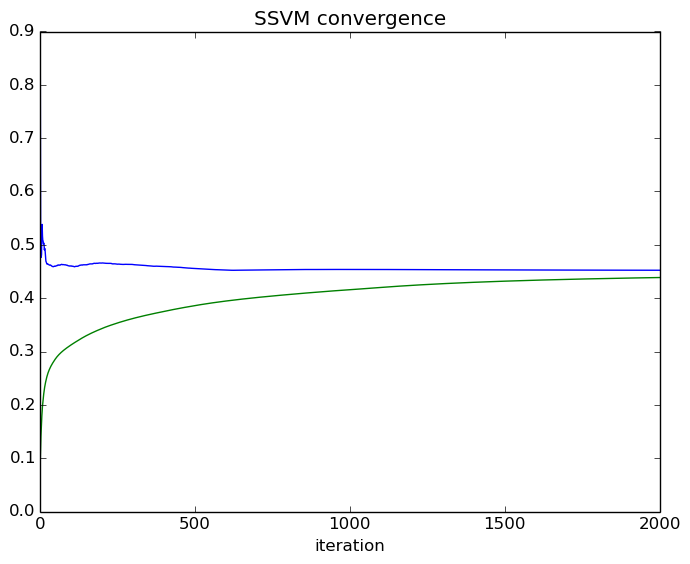

In [18]:
plot(progress.primal)
plot(progress.dual);
title("SSVM convergence");
xlabel("iteration");

In [10]:
w = model.w;
z = w[1] + w[2] * xr + w[3] * xr.^2 + w[4] * xr.^3;
F = yr*z' - 0.5 * yr.^2 * ones(size(z))' * w[5]; # scoring function
F_ = F .- maximum(F, 1); # column rescaled
y_fit = oracleCB(param, model, xr);

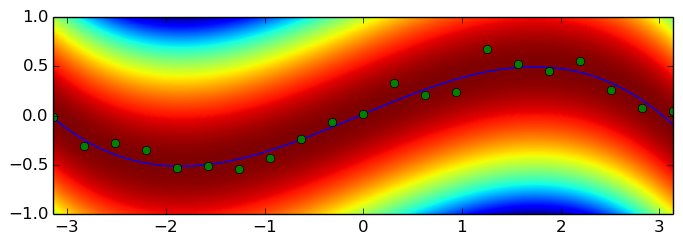

In [12]:
imshow(F_, extent=[minimum(x), maximum(x), -1, 1], origin="lower")
plot(xr, y_fit)
plot(x, y, "o")
xlim([minimum(x), maximum(x)]);